In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import pickle
import math
import igraph as ig

In [2]:
#df = pd.read_csv('extracted_games_attributes.csv')
df = pd.read_csv('extracted_games_attributes_v4.csv')
#df = pd.read_csv('extracted_games_attributes_sample.csv')

#print(df)

#Preprocessing

In [3]:
print(f"Number of games originally: {len(df.index)}")

num_games_deleted = 0

for index, row in df.iterrows():
    if (row['positive'] + row['negative']) <= 500:
        df.drop(index, inplace=True)
        num_games_deleted += 1

print(f"Number of games deleted: {num_games_deleted}")
print(f"Number of games now: {len(df.index)}")
print()

drop_percentage = 0.685
df = df.sample(frac=1-drop_percentage)

print(f"Number of games in sample: {len(df.index)}")

app_id_list = df['appid'].tolist()
app_id_np_arr = np.array(app_id_list)
with open('app_id_list.npy', 'wb') as f:
    np.save(f,app_id_np_arr)

Number of games originally: 23396
Number of games deleted: 15243
Number of games now: 8153

Number of games in sample: 2568


#Binary Matrix Creation

In [4]:
# Create the binary matrix for 'Genre' attribute -----
all_genre_set = set()

for genres in df['genre']:
    if not pd.isna(genres):
        all_genre_set.update(genres.replace(" ", "").split(','))

sorted_genre_list = list(sorted(all_genre_set))
genre_dict = dict.fromkeys(sorted_genre_list)
genre_dict.update((k, i) for i, k in enumerate(genre_dict))
genre_attr_mtx = np.zeros((len(df),len(genre_dict)), int)

for index, genres in enumerate(df['genre']):
    if not pd.isna(genres):
        genres_list = genres.replace(" ", "").split(',')
        for genre in genres_list:
            genre_attr_mtx[index][genre_dict.get(genre)] = 1

In [5]:
# Create the binary matrix for 'Tags' attribute -----
# Rows: games, Columns: tags
print("calculating tags")
all_tags_set = set()

for tags in df['tags']:
    if tags != "[]":
        tags_list = [tag_info.split(':')[0].strip() for tag_info in tags.replace("{", "").split(',')]
        all_tags_set.update(tags_list)

sorted_tags_list = list(sorted(all_tags_set))
tags_dict = dict.fromkeys(sorted_tags_list)
tags_dict.update((k, i) for i, k in enumerate(tags_dict))
tags_attr_mtx = np.zeros((len(df),len(tags_dict)), int)

for index, tags in enumerate(df['tags']):
    if tags != "[]":
        tags_list = [tag_info.split(':')[0].strip() for tag_info in tags.replace("{", "").split(',')]

        # Limit the number of tags per game to 7
        max_tags = 7
        if len(tags_list) > max_tags:
            tags_list = tags_list[:max_tags]

        print(tags_list)
        for tag in tags_list:
            tags_attr_mtx[index][tags_dict.get(tag)] = 1

calculating tags
["'Casual'", "'Indie'", "'Puzzle'", "'Anime'"]
["'Multiplayer'", "'Free to Play'", "'Puzzle'", "'Horror'", "'Investigation'", "'Adventure'", "'Logic'"]
["'RPG'", "'Turn-Based'", "'Strategy'", "'Indie'", "'Tactical'", "'Turn-Based Strategy'", "'Story Rich'"]
["'Sci-fi'", "'Stealth'", "'Female Protagonist'", "'Adventure'", "'Action'", "'Indie'", "'Third Person'"]
["'RPG'", "'Action'", "'Demons'", "'Loot'", "'Action RPG'", "'Zombies'", "'Third-Person Shooter'"]
["'Simulation'", "'Strategy'", "'Space'", "'Realistic'", "'Sci-fi'", "'Science'", "'Singleplayer'"]
["'Zombies'", "'Strategy'", "'Survival'", "'Indie'", "'Pixel Graphics'", "'Simulation'", "'Tower Defense'"]
["'Anime'", "'Sexual Content'", "'Action'", "'Nudity'", "'Hack and Slash'", "'Female Protagonist'", "'Mature'"]
["'RPG'", "'Indie'", "'Action'", "'Adventure'", "'Simulation'", "'Pixel Graphics'", "'Loot'"]
["'Action'", "'Strategy'", "'FPS'", "'Tactical'", "'World War II'", "'War'", "'Shooter'"]
["'Hidden Object

In [6]:
# Create the binary matrix for 'Positive and Negative Reviews' attribute -----
print("calculating reviews")
# Boolean is the percent of positive reviews >60%
reviews_attr_mtx = np.zeros((len(df),1), int)

for index, row in enumerate(df.iterrows()):
    #print(index)
    row_index, row_data = row
    pos = row_data['positive']
    neg = row_data['negative']
    #print(pos, neg, math.ceil(pos/(neg+pos)*100) )
    
    if math.ceil(pos/(neg+pos)*100) > 60:
        reviews_attr_mtx[index][0] = 1
    print(math.ceil(pos/(neg+pos)*100), reviews_attr_mtx[index])
print(reviews_attr_mtx[len(reviews_attr_mtx)-1])

calculating reviews
98 [1]
88 [1]
90 [1]
79 [1]
58 [0]
91 [1]
68 [1]
94 [1]
71 [1]
95 [1]
91 [1]
62 [1]
79 [1]
92 [1]
97 [1]
93 [1]
70 [1]
93 [1]
92 [1]
88 [1]
86 [1]
84 [1]
81 [1]
57 [0]
89 [1]
88 [1]
56 [0]
55 [0]
79 [1]
61 [1]
76 [1]
92 [1]
96 [1]
53 [0]
76 [1]
79 [1]
89 [1]
61 [1]
92 [1]
86 [1]
98 [1]
85 [1]
56 [0]
81 [1]
84 [1]
52 [0]
82 [1]
98 [1]
90 [1]
68 [1]
68 [1]
94 [1]
87 [1]
81 [1]
86 [1]
93 [1]
99 [1]
48 [0]
94 [1]
88 [1]
89 [1]
94 [1]
78 [1]
93 [1]
91 [1]
81 [1]
62 [1]
99 [1]
91 [1]
69 [1]
95 [1]
92 [1]
92 [1]
27 [0]
97 [1]
87 [1]
74 [1]
92 [1]
58 [0]
81 [1]
74 [1]
82 [1]
40 [0]
97 [1]
93 [1]
89 [1]
88 [1]
85 [1]
76 [1]
90 [1]
86 [1]
86 [1]
89 [1]
76 [1]
86 [1]
92 [1]
91 [1]
79 [1]
82 [1]
77 [1]
93 [1]
76 [1]
63 [1]
77 [1]
84 [1]
75 [1]
93 [1]
80 [1]
66 [1]
95 [1]
82 [1]
74 [1]
78 [1]
85 [1]
39 [0]
93 [1]
79 [1]
85 [1]
92 [1]
46 [0]
89 [1]
90 [1]
92 [1]
63 [1]
86 [1]
89 [1]
77 [1]
95 [1]
58 [0]
70 [1]
92 [1]
76 [1]
64 [1]
75 [1]
71 [1]
84 [1]
88 [1]
99 [1]
68 [1]
97 [1]


87 [1]
90 [1]
75 [1]
95 [1]
94 [1]
92 [1]
51 [0]
91 [1]
92 [1]
95 [1]
75 [1]
70 [1]
92 [1]
84 [1]
93 [1]
83 [1]
62 [1]
94 [1]
92 [1]
87 [1]
73 [1]
76 [1]
97 [1]
75 [1]
97 [1]
88 [1]
63 [1]
99 [1]
93 [1]
92 [1]
72 [1]
64 [1]
56 [0]
87 [1]
83 [1]
92 [1]
85 [1]
77 [1]
93 [1]
80 [1]
100 [1]
94 [1]
98 [1]
83 [1]
86 [1]
96 [1]
97 [1]
90 [1]
73 [1]
71 [1]
63 [1]
97 [1]
85 [1]
95 [1]
92 [1]
73 [1]
80 [1]
97 [1]
81 [1]
89 [1]
74 [1]
91 [1]
91 [1]
71 [1]
85 [1]
95 [1]
83 [1]
95 [1]
90 [1]
96 [1]
96 [1]
86 [1]
74 [1]
98 [1]
97 [1]
70 [1]
83 [1]
79 [1]
80 [1]
97 [1]
95 [1]
86 [1]
92 [1]
98 [1]
98 [1]
75 [1]
81 [1]
94 [1]
92 [1]
69 [1]
86 [1]
77 [1]
69 [1]
70 [1]
83 [1]
85 [1]
47 [0]
52 [0]
94 [1]
87 [1]
90 [1]
56 [0]
82 [1]
66 [1]
67 [1]
38 [0]
80 [1]
83 [1]
74 [1]
94 [1]
70 [1]
95 [1]
76 [1]
57 [0]
91 [1]
88 [1]
55 [0]
79 [1]
87 [1]
70 [1]
92 [1]
93 [1]
97 [1]
90 [1]
97 [1]
51 [0]
91 [1]
90 [1]
98 [1]
60 [0]
94 [1]
89 [1]
75 [1]
95 [1]
90 [1]
89 [1]
80 [1]
45 [0]
91 [1]
86 [1]
75 [1]
97 [1]
85 [1

#Calculating Dice Similarity (DS)

In [7]:
# Create Dice similarity matrix for 'Genre' attribute -----
genre_ds = np.zeros((len(df),len(df)))
n_values = np.zeros(len(df))

start = time.time()

print("calculating genre_ds")

for i in range(len(genre_attr_mtx)):
    n_values[i] = np.sum(genre_attr_mtx[i])

for i in range(len(genre_attr_mtx)):
    for j in range(i, len(genre_attr_mtx)):
        if i != j:
            matching_count = np.sum((genre_attr_mtx[i] & genre_attr_mtx[j]) == 1)
            if n_values[i] + n_values[j] == 0:
                ds = 0
            else:
                ds = 2 * matching_count / (n_values[i] + n_values[j])
            genre_ds[i][j] = ds
            genre_ds[j][i] = ds
            
end = time.time()
print(f"Took {end - start} seconds")

calculating genre_ds
Took 32.15203523635864 seconds


In [8]:
# Create Dice similarity matrix for 'Tags' attribute -----
tags_ds = np.zeros((len(df),len(df)))
n_values = np.zeros(len(df))
start = time.time()
print("calculating trait_ds")

for i in range(len(tags_attr_mtx)):
    n_values[i] = np.sum(tags_attr_mtx[i])

for i in range(len(tags_attr_mtx)):
    for j in range(i, len(tags_attr_mtx)):
        if i != j:
            matching_count = np.sum((tags_attr_mtx[i] & tags_attr_mtx[j]) == 1)
            if n_values[i] + n_values[j] == 0:
                ds = 0
            else:
                ds = 2 * matching_count / (n_values[i] + n_values[j])
            tags_ds[i][j] = ds
            tags_ds[j][i] = ds

end = time.time()
print(f"Took {end - start} seconds")

calculating trait_ds
Took 35.82455801963806 seconds


In [9]:
# Create Dice similartiy matrix for 'Positive and Negative' attributes -----
review_ds = np.zeros((len(df),len(df)))
start = time.time()
print("calculating review_ds")

for i in range(len(reviews_attr_mtx)):
    for j in range(i, len(reviews_attr_mtx)):
        if i != j:
            val = reviews_attr_mtx[i][0] + reviews_attr_mtx[j][0]
            if val == 0 or val == 1:
                ds = 0
            else:
                ds = 1
            review_ds[i][j] = ds
            review_ds[j][i] = ds

end = time.time()
print(f"Took {end - start} seconds")

calculating review_ds
Took 4.1316235065460205 seconds


# Calculating Multiattribute Similarity (MAS)
--> using the Dice similarities

In [10]:
start = time.time()
print("calculating MAS")

MAS = np.zeros((len(df),len(df)))

ds_attr = 3

for i in range(len(df)):
    for j in range(i, len(df)):
        summation_ds = genre_ds[i][j] + tags_ds[i][j] + review_ds[i][j]
        mas_val = summation_ds / ds_attr

        if mas_val > 0.70:
            MAS[i][j] = 1 - mas_val  # Inverse the normalized edge weight
            MAS[j][i] = 1 - mas_val

end = time.time()
print(f"Took {end - start} seconds")

calculating MAS
Took 3.7573323249816895 seconds


In [11]:
print(MAS)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [31]:
def displayWeightDistribution(M):
  net = nx.from_numpy_array(M)

  print("Number of Nodes:", len(net.nodes()))
  print("Number of Edges:", len(net.edges()))
  print("Average Degree:", np.mean(list(d for n, d in net.degree())))

  edges = net.edges()
  weights = [M[u][v] for u,v in edges]
  avgW = np.mean(weights)
  maxW = np.max(weights)

  print("Average Weight:", avgW)
  print("Max Weight:", maxW)

  # get the list of all node degrees and sort
  weight_sequence = np.sort(weights)
  # weight_sequence = np.log(weight_sequence)
  print("min: ", np.min(weight_sequence), "max:", np.max(weight_sequence))
  print("0.5%:", np.percentile(weight_sequence, 0.5))
  mean = np.mean(weight_sequence)
  std = np.std(weight_sequence)
  print("cutoffs (outside 3x std):", mean - 3 * std, mean + 3 * std)
  # weight_sequence = weight_sequence[(weight_sequence > mean - 3 * std) & (weight_sequence < mean + 3 * std)]
  weight_sequence = weight_sequence[weight_sequence < 0.4]


  # draw a bar plot of degree probabilities
  plt.hist(weight_sequence, bins=100)
  plt.xlim(0, 0.4)
  plt.title("Weight distribution")
  plt.xlabel("Weight")
  plt.ylabel("Count")

Number of Nodes: 2568
Number of Edges: 94428
Average Degree: 73.54205607476635
Average Weight: 0.2424902110474093
Max Weight: 0.29999999999999993
min:  0.02564102564102555 max: 0.29999999999999993
0.5%: 0.09523809523809523
cutoffs (outside 3x std): 0.11048303553477126 0.3744973865600473


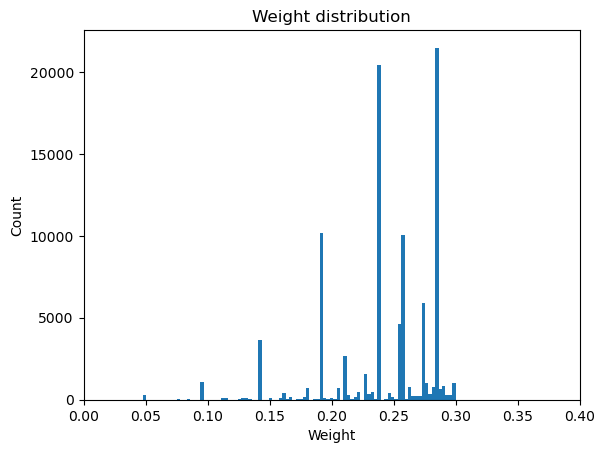

In [32]:
displayWeightDistribution(MAS)

#Network Analysis and Visualization

In [ ]:
start = time.time()
print("calculating")
graph_ig = ig.Graph.Weighted_Adjacency(MAS, mode='undirected')
graph_nx = nx.from_numpy_array(MAS)

zero_degree_nodes = [v.index for v in graph_ig.vs if v.degree() == 0]

# Delete the vertices with zero degree
graph_ig.delete_vertices(zero_degree_nodes)

i = graph_ig.community_infomap()
print(len(i))

end = time.time()
print(f"Took {end - start} seconds")

calculating
41
Took 3.6501126289367676 seconds


In [15]:
start = time.time()
#graph = nx.from_numpy_array(MAS)
print("calculating")
# plt.figure(figsize=(10,8))
# pos = nx.kamada_kawai_layout(graph)

# node_options = {"node_color": 'blue', "node_size": 15}
# edge_options = {"width": .50, "alpha": .5, "edge_color": "black"}

# print("drawing")

# nx.draw_networkx_nodes(graph, pos, **node_options)
# nx.draw_networkx_edges(graph, pos, **edge_options)

# plt.show()


pal = ig.drawing.colors.ClusterColoringPalette(len(i))
graph_ig.vs['color'] = pal.get_many(i.membership)

out_fig_name = "graph.eps"

visual_style = {}

# Define colors used for outdegree visualization
colours = ['#fecc5c', '#a31a1c']

# Set bbox and margin
visual_style["bbox"] = (3000,3000)
visual_style["margin"] = 17

# Set vertex colours
#visual_style["vertex_color"] = 'grey'

# Set vertex size
visual_style["vertex_size"] = 10

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# Don't curve the edges
visual_style["edge_curved"] = False

# Set the layout
my_layout = graph_ig.layout_fruchterman_reingold()
visual_style["layout"] = my_layout

# Plot the graph
ig.plot(graph_ig, out_fig_name, **visual_style).show()

end = time.time()
print(f"Took {end - start} seconds")

calculating
Took 10.551774263381958 seconds


In [16]:
#print(graph[1][3])
print(ig.summary(graph_ig))
print(graph_ig.get_adjacency(attribute="weight")[0])

IGRAPH U-W- 2332 94428 -- 
+ attr: color (v), weight (e)
None
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2787878787878788, 0.26262626262626265, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2787878787878788, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2962962962962963, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21818181818181814, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2787878787878788, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1515151515151515, 0, 0.26262626262626265, 0, 0, 0, 0, 0, 0.2727272727272728, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20000000000000007, 0.1515151515151515, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2787878787878788, 0, 0, 0, 0, 0, 0, 0, 0.2787878787878788, 0, 0, 0, 0, 0, 0.2787878787878788, 0, 0, 0, 0, 0.26262626262626265, 0, 0, 0, 0,

#Item Clustering

In [17]:
# start = time.time()
# communities = nx.community.louvain_communities(graph)
# num_communities = len(nx.community.louvain_communities(graph))
# print(num_communities)

# end = time.time()
# print(f"Took {end - start} seconds")

In [18]:
# print(communities)

In [19]:
# start = time.time()
# hsv = plt.get_cmap("tab10")
# colors = hsv(np.linspace(0, 1.0, num_communities+1))

# plt.figure(figsize=(10,8))

# edge_options = {"width": .50, "alpha": .5, "edge_color": "black"}

# for community_id, nodes in enumerate(communities):
#     nx.draw_networkx_nodes(graph, pos, nodelist=list(nodes), node_color=[colors[community_id]], node_size = 15)
# nx.draw_networkx_edges(graph, pos, **edge_options)
# plt.show()

# end = time.time()
# print(f"Took {end - start} seconds")

# Calculate Degree Centrality (DC)

In [20]:
from networkx.algorithms.centrality import degree_centrality

start = time.time()
print("calculating DC")

degree_centrality_dict = degree_centrality(graph_nx)

end = time.time()
print(f"Took {end - start} seconds")

calculating DC
Took 0.001995086669921875 seconds


In [21]:
print("Degree Centrality Dict")
print(degree_centrality_dict)

Degree Centrality Dict
{0: 0.06622516556291391, 1: 0.00506427736657577, 2: 0.031554343591741335, 3: 0.08998831320607713, 4: 0.0, 5: 0.019477989871445268, 6: 0.02025710946630308, 7: 0.06271912738605376, 8: 0.08531359563693026, 9: 0.017919750681729647, 10: 0.02025710946630308, 11: 0.004674717569146864, 12: 0.03272302298402805, 13: 0.007401636151149201, 14: 0.007401636151149201, 15: 0.019477989871445268, 16: 0.023763147643163226, 17: 0.03856641994546163, 18: 0.04285157771717959, 19: 0.0654460459680561, 20: 0.08609271523178808, 21: 0.1098558628749513, 22: 0.019477989871445268, 23: 0.0, 24: 0.002337358784573432, 25: 0.08336579664978574, 26: 0.0, 27: 0.0, 28: 0.0027269185820023374, 29: 0.07947019867549669, 30: 0.028827425009738995, 31: 0.07557460070120764, 32: 0.018698870276587457, 33: 0.0, 34: 0.03778730035060382, 35: 0.01753019088430074, 36: 0.01675107128944293, 37: 0.009738994935722634, 38: 0.017919750681729647, 39: 0.004674717569146864, 40: 0.010518114530580444, 41: 0.022984028048305415,

# Calculate Closeness Centrality (CC)


In [22]:
start = time.time()
print("calculating CC")

# # Load closeness_centrality_dict from pickle file instead of re-computing
# closeness_centrality_dict = {}
# with open('closeness_centrality_dict.pickle', 'rb') as handle:
#     closeness_centrality_dict = pickle.load(handle)

closeness_list = graph_ig.closeness(vertices=None, weights='weight', normalized=True)
closeness_centrality_dict = {k: v for k, v in enumerate(closeness_list)}

max_centrality_val = max(closeness_centrality_dict.values())
for key, value in closeness_centrality_dict.items():
    closeness_centrality_dict[key] = value / max_centrality_val

    if math.isnan(closeness_centrality_dict[key]):
        closeness_centrality_dict[key] = 0

end = time.time()
print(f"Took {end - start} seconds")

calculating CC
Took 2.266577959060669 seconds


In [23]:
print("Closeness Centrality Dict")
print(closeness_centrality_dict)

Closeness Centrality Dict
{0: 0.12288046412244848, 1: 0.09482810806685252, 2: 0.11270983938726872, 3: 0.13810603848702524, 4: 0.1021685374491953, 5: 0.11782339348759988, 6: 0.10196128638273008, 7: 0.13708154226808889, 8: 0.10696975681576128, 9: 0.1075809148015274, 10: 0.09357073021271113, 11: 0.11128248764049037, 12: 0.08647695529713917, 13: 0.10599406030135193, 14: 0.10090709377248772, 15: 0.11126752403694613, 16: 0.12732179046460537, 17: 0.12048961740374689, 18: 0.1280182032321199, 19: 0.13167420846726352, 20: 0.1443489837451713, 21: 0.11067434280637033, 22: 0.08761179374796585, 23: 0.13038581364447716, 24: 0.08840648404601589, 25: 0.12208243409236459, 26: 0.11529322461075368, 27: 0.11299568985466432, 28: 0.08909183920645647, 29: 0.11498882322703297, 30: 0.11088906793254219, 31: 0.11002729186989978, 32: 0.0905698756141734, 33: 0.10600919940016852, 34: 0.09921187301179799, 35: 0.08876649284444615, 36: 0.10561471587453877, 37: 0.13125775827667532, 38: 0.11614845060412138, 39: 0.0994986

In [24]:
# Save closeness centrality dict to a pickle file

with open("closeness_centrality_dict.pickle", 'wb') as handle:
    pickle.dump(closeness_centrality_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Calculate Betweenness Centrality (BC)

In [ ]:
start = time.time()
print("calculating CC")

# # Load closeness_centrality_dict from pickle file instead of re-computing
# betweenness_centrality_dict = {}
# with open('betweenness_centrality_dict.pickle', 'rb') as handle:
#     betweenness_centrality_dict = pickle.load(handle)

betweenness_list = graph_ig.betweenness(weights='weight')
betweenness_centrality_dict = {k: v for k, v in enumerate(betweenness_list)}

end = time.time()
print(f"Took {end - start} seconds")

calculating CC
Took 6.859879970550537 seconds


In [26]:
print("Betweenness Centrality Dict")
print(betweenness_centrality_dict)

Betweenness Centrality Dict
{0: 6555.279148629148, 1: 12.357142857142858, 2: 2795.7096646530326, 3: 3838.577620129274, 4: 2780.5208036862623, 5: 1193.4388888888886, 6: 698.6731852681173, 7: 21223.710074501556, 8: 1978.1054777605207, 9: 336.55680391678015, 10: 28.0, 11: 837.6461739241154, 12: 75.66666666666666, 13: 347.15999278499277, 14: 274.41125970434797, 15: 7160.360062949043, 16: 2878.367667550933, 17: 9399.11986657135, 18: 5910.866632165298, 19: 5290.291482674663, 20: 22610.310471064167, 21: 3602.2166666666667, 22: 22.333333333333332, 23: 3236.1360435116417, 24: 0.0, 25: 5785.4855284584055, 26: 1121.4177655677647, 27: 327.0662928566657, 28: 10.556944444444445, 29: 113.2604036377381, 30: 2697.0, 31: 398.815223665224, 32: 0.0, 33: 29.325, 34: 12.5, 35: 7.475, 36: 254.1887973137972, 37: 480.9276237067859, 38: 436.3666666666666, 39: 41.603683353683344, 40: 17.0, 41: 287.3045449406635, 42: 98.70292918255012, 43: 2661.4023809523815, 44: 4599.271434247812, 45: 655.2390236131445, 46: 20.9

In [27]:
# Save betweenness centrality dict to a pickle file

with open("betweenness_centrality_dict.pickle", 'wb') as handle:
    pickle.dump(betweenness_centrality_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Calculate Average Centrality (AC)

In [28]:
average_centrality_list = []

for i in range(len(df)):
    avg = (degree_centrality_dict[i] + closeness_centrality_dict[i] + betweenness_centrality_dict[i]) / 3
    average_centrality_list.append(avg)

print("Average Centrality List")
print(average_centrality_list)

KeyError: 2332

#Calculate Ego-Focused Centralities (CEF)


In [ ]:
start = time.time()
print("Calculating Ego-Focused Centralities")

# Ego_centrality_matrix - node as the Target node (rows) x ego-focused centrality value for node i and T (columns)
ego_centrality_matrix = np.zeros((len(df),len(df)))

# # Load closeness_centrality_dict from pickle file instead of re-computing
# with open('ego_centrality_matrix.pickle', 'rb') as handle:
#     ego_centrality_matrix = pickle.load(handle)

for i in range(len(df)):
    if (i % 10) == 0:
        print(f"i reached: {i}")
    for j in range(len(df)):
        print(f"j: {j}")
        if i != j:
          num_links_i_T = len(graph_ig.get_shortest_paths(i, to=j, output="vpath")[0]) - 1  # weight is ignored b/c we just want num of links between source and target nodes
          
          if num_links_i_T != 0:
              ego_centrality_matrix[j][i] = average_centrality_list[i] / num_links_i_T
          else:
              ego_centrality_matrix[j][i] = 0

end = time.time()
print(f"Took {end - start} seconds")

In [ ]:
print("Ego-Focused Centralities")
print(ego_centrality_matrix)

In [ ]:
# Save ego centrality matrix to a pickle file

with open("ego_centrality_matrix.pickle", 'wb') as handle:
    pickle.dump(ego_centrality_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Testing the Recommendations

> All items are assigned a CEF value, and the top n items in the list are recommended to the user



In [ ]:
# Recommendations that are similar to game 0 - "Cooking Companions"
game_index = 0

print(df.iloc[game_index])

In [ ]:
similarity_list = np.array(ego_centrality_matrix[game_index])

sort_index = np.argsort(-similarity_list)  # Descending sorted order --> largest to smallest centrality value
print(sort_index)
print()

sort_similarity = sorted(similarity_list, reverse=True)
print(sort_similarity)

In [ ]:
print(similarity_list[sort_index[0:3]])
print()
print(df.iloc[sort_index[0:3]])